In [2]:
import sys
import os
os.chdir("/home/debian/PhenPred")
import importlib
import PhenPred
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from PhenPred.vae import shap_folder, plot_folder
import Shap_functions

/home/debian/miniconda3/envs/mosa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
time_alldat = "20240805_132345" #all datasets, no dipvae
time_alldat_dis = "20240805_131847" #all datasets w/ disentanglement, lambda_d = 0.001, lambda_od = 0.001

target_latent = "latent"
target_drug = "drugresponse"

In [4]:
df = pd.read_feather(
    f"{shap_folder}/files/{time_alldat}_shap_values_top_features_{target_drug}.feather"
)

In [4]:
df

,Sample_ID,target_name,omics_feature,Shap_value
13707,SIDM00001,1;Erlotinib;GDSC1,proteomics_AASDHPPT,-0.000298
13708,SIDM00003,1;Erlotinib;GDSC1,proteomics_AASDHPPT,-0.000039
13709,SIDM00005,1;Erlotinib;GDSC1,proteomics_AASDHPPT,-0.000083
13710,SIDM00006,1;Erlotinib;GDSC1,proteomics_AASDHPPT,0.000048
13711,SIDM00007,1;Erlotinib;GDSC1,proteomics_AASDHPPT,-0.000257
...,...,...,...,...
356377,SIDM01979,2510;AZD1390;GDSC2,conditionals_mut_ZNF626,0.000000
356378,SIDM01980,2510;AZD1390;GDSC2,conditionals_mut_ZNF626,0.000000
356379,SIDM01981,2510;AZD1390;GDSC2,conditionals_mut_ZNF626,0.000000
356380,SIDM01983,2510;AZD1390;GDSC2,conditionals_mut_ZNF626,0.000215


In [5]:
drugs_of_interest =["1193;UNC0638;GDSC2", "1593;Entinostat;GDSC2", '279;BIX02189;GDSC1', '1008;Methotrexate;GDSC2']

for drug in drugs_of_interest:
    df_drug = df.loc[df['target_name'] == drug].copy()
    df_drug['abs_Shap_value'] = df_drug['Shap_value'].abs()
                
    grouped_df = df_drug.groupby('omics_feature')['abs_Shap_value'].mean().reset_index()
    grouped_df.rename(columns={'abs_Shap_value': 'avg_abs_Shap_value'}, inplace=True)

    ordered_df = grouped_df.sort_values(by='avg_abs_Shap_value', ascending=False).reset_index(drop=True)
    metabolomics_rows = ordered_df[ordered_df['omics_feature'].str.contains('metabolomics', case=False, na=False)].reset_index(drop=True)
    print("metabolomics_1-methylnicotinamide is the ", metabolomics_rows[metabolomics_rows['omics_feature'] == 'metabolomics_1-methylnicotinamide'].index[0] +1, "th most important metabolomic feature to ", drug, "with SHAP value", metabolomics_rows[metabolomics_rows['omics_feature'] == 'metabolomics_1-methylnicotinamide']["avg_abs_Shap_value"].values[0])


metabolomics_1-methylnicotinamide is the  19 th most important metabolomic feature to  1193;UNC0638;GDSC2 with SHAP value 0.0015235021667760998
metabolomics_1-methylnicotinamide is the  18 th most important metabolomic feature to  1593;Entinostat;GDSC2 with SHAP value 0.001411531779382797
metabolomics_1-methylnicotinamide is the  26 th most important metabolomic feature to  279;BIX02189;GDSC1 with SHAP value 0.0012810381483913328
metabolomics_1-methylnicotinamide is the  16 th most important metabolomic feature to  1008;Methotrexate;GDSC2 with SHAP value 0.0015096963230466186


In [5]:
df_feature = df.loc[df['omics_feature'] == "metabolomics_1-methylnicotinamide"].copy()
df_feature['abs_Shap_value'] = df_feature['Shap_value'].abs()
grouped_df = df_feature.groupby('target_name')['abs_Shap_value'].mean().reset_index()
grouped_df.rename(columns={'abs_Shap_value': 'avg_abs_Shap_value'}, inplace=True)
ordered_df = grouped_df.sort_values(by='avg_abs_Shap_value', ascending=False).reset_index(drop=True)
list = ordered_df.head(10)
list.loc[:, 'target_name'] = list['target_name'].apply(lambda x: ';'.join(x.split(';')[1:]))

/tmp/ipykernel_90221/2836892077.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


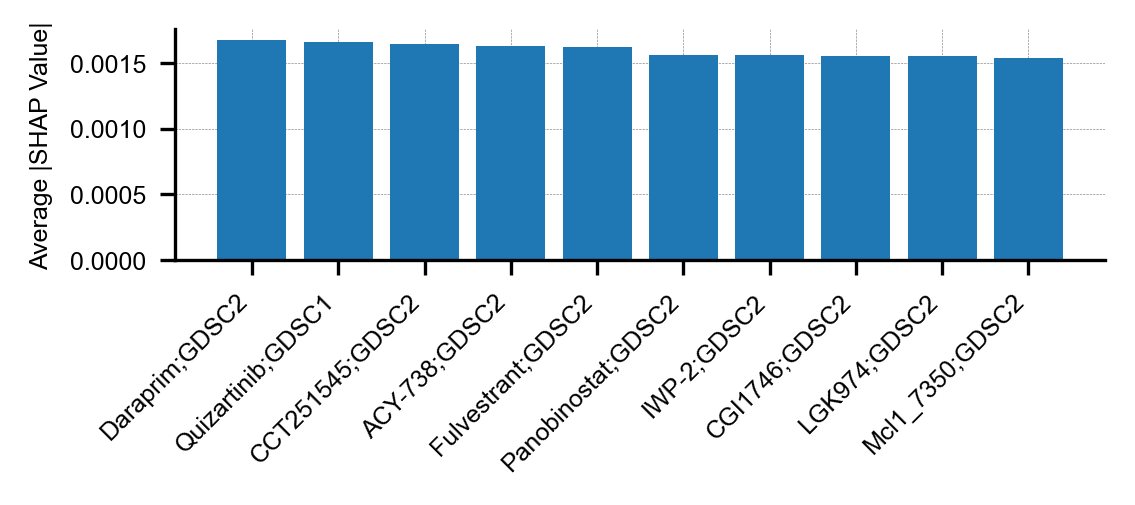

In [6]:
drugs = list["target_name"].values
values = list["avg_abs_Shap_value"].values
x = np.arange(len(drugs))

plt.figure(figsize=(4, 1))

plt.bar(x, values, linewidth=2)
plt.xticks(x, drugs, rotation=45, ha="right") 
plt.ylabel('Average |SHAP Value|') 

plt.tight_layout() 
plt.show()

In [8]:
df_dis = pd.read_feather(
    f"{shap_folder}/files/{time_alldat_dis}_shap_values_top_features_{target_drug}.feather"
)

In [1]:
df_feature = df_dis.loc[df['omics_feature'] == "metabolomics_1-methylnicotinamide"].copy()
df_feature['abs_Shap_value'] = df_feature['Shap_value'].abs()
grouped_df = df_feature.groupby('target_name')['abs_Shap_value'].mean().reset_index()
grouped_df.rename(columns={'abs_Shap_value': 'avg_abs_Shap_value'}, inplace=True)
ordered_df = grouped_df.sort_values(by='avg_abs_Shap_value', ascending=False).reset_index(drop=True)
list_dis = ordered_df.head(10)
list_dis.loc[:, 'target_name'] = list_dis['target_name'].apply(lambda x: ';'.join(x.split(';')[1:]))

NameError: name 'df_dis' is not defined

/tmp/ipykernel_81923/209505159.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


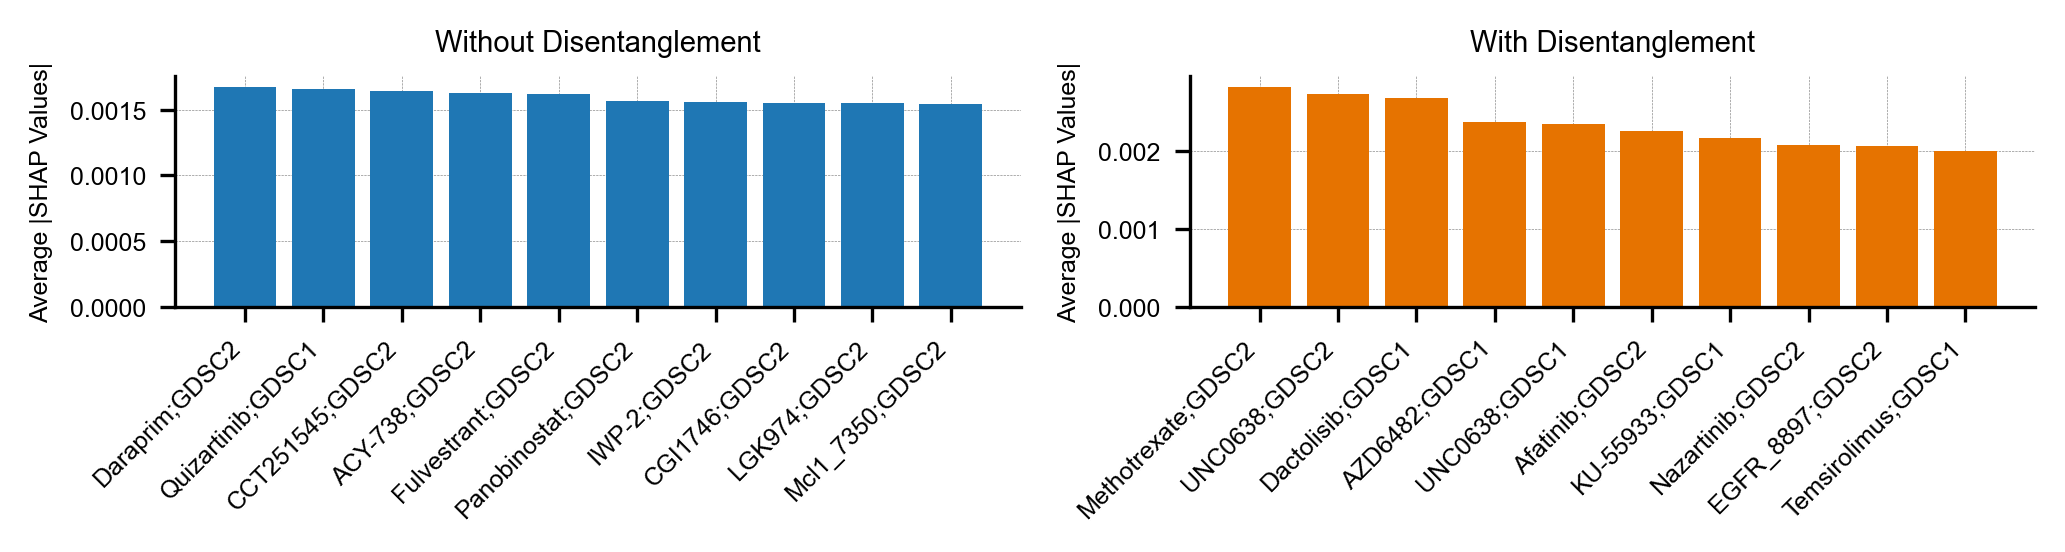

In [ ]:
drugs_1 = list["target_name"].values
values_1 = list["avg_abs_Shap_value"].values

drugs_2 = list_dis["target_name"].values
values_2 = list_dis["avg_abs_Shap_value"].values

fig, axs = plt.subplots(1, 2, figsize=(8, 1))
x1 = np.arange(len(drugs_1))
x2 = np.arange(len(drugs_2))

axs[0].bar(x1, values_1, linewidth=2)
axs[0].set_xticks(x1)
axs[0].set_xticklabels(drugs_1, rotation=45, ha="right")
axs[0].set_ylabel('Average |SHAP Values|')
axs[0].set_title('Without Disentanglement', fontsize=7)

axs[1].bar(x2, values_2, linewidth=2, color='#e67300')
axs[1].set_xticks(x2)
axs[1].set_xticklabels(drugs_2, rotation=45, ha="right")
axs[1].set_ylabel('Average |SHAP Values|')
axs[1].set_title('With Disentanglement', fontsize=7)

plt.tight_layout()
plt.show()